In [1]:
# MobileNet_Emotion_Detection

import numpy as np
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image 
# tf.keras.preprocessing.image.load_img(image_path)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
# tf.keras.applications.imagenet_utils.decode_predictions(preds, top=5)

from IPython.display import Image
from sklearn.metrics import confusion_matrix

import itertools
import os
import shutil
import random
# import glob
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
"""
(noticed: the following codes activate only when using GPU to run the model, 
 but I'm not using GPU support I think? )
"""
# check to be sure that TensorFlow is able to identify the GPU

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Num GPUs Available:  0

# set_memory_growth() allocate only as much GPU memory as needed at a given time, 
# and continues to allocate more when needed

# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# (IndexError                                Traceback (most recent call last)
# <ipython-input-3-df3199446273> in <module>
#      37 # set_memory_growth() allocate only as much GPU memory as needed at a given time,
#      38 # and continues to allocate more when needed
# ---> 39 tf.config.experimental.set_memory_growth(physical_devices[0], True)

# IndexError: list index out of range)

Num GPUs Available:  0


In [3]:
# downloading a copy of a single pretrained MobileNet, 
# with weights that were saved from being trained on ImageNet images
mobile = tf.keras.applications.mobilenet.MobileNet()

In [4]:
# prepare_image() takes an file name, and processes the image to get it in a format that MobileNet expects
def prepare_image(file):
    img_path = 'D:/Deep_Learning_Projects/MobileNet-test-samples/'  # defining the relative path to the images
    # load_img(img_path) takes the image file, and resizing it to be of size (224, 224), 
    # and returns an instance of a PIL image
    img = tf.keras.preprocessing.image.load_img(img_path + file, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)    # then converting the PIL image into an array
    # input_array = np.array([input_array])                    # converting single image to a batch

    # numpy.expand_dims(a, axis) insert a new dimension in "axis th" dimension, and 
    # all previous dimensions would be push to the right
    img_array_dims_expand = np.expand_dims(img_array, axis=0)
    # preprocess_inout() scale the pixel values in the image between -1 to 1, same format as the images that 
    # MobileNet was originally trained on, and return the preprocessed image data as a numpy array
    return tf.keras.applications.mobilenet.preprocess_input(img_array_dims_expand)


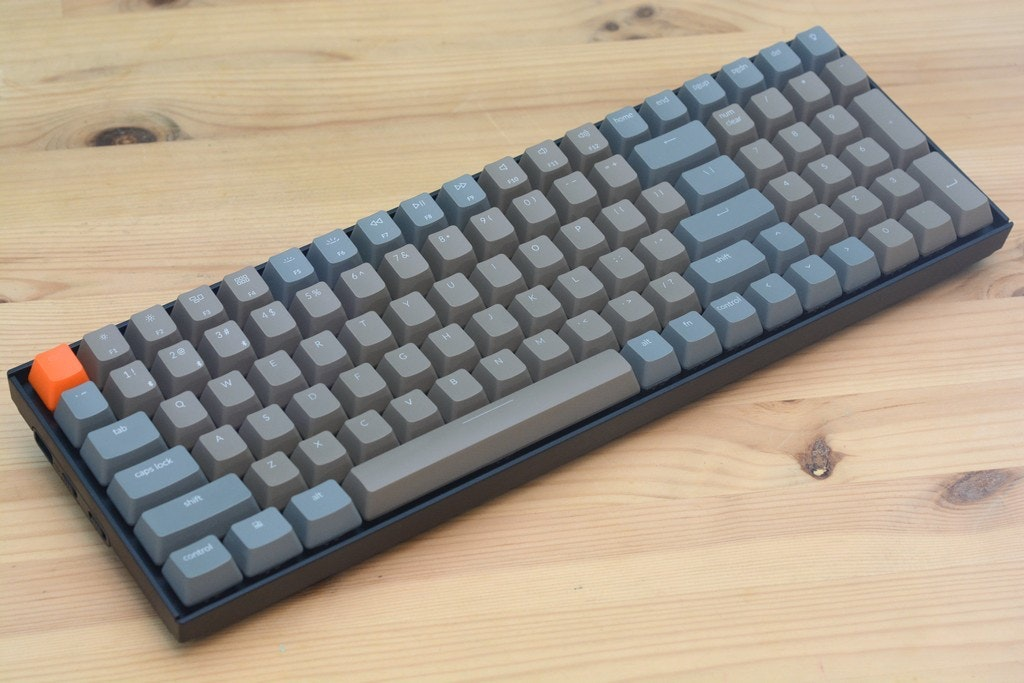

In [5]:
# just showing the test image on screen, test1 here is a wireless keyboard
# from IPython.display import Image
Image(filename='D:/Deep_Learning_Projects/MobileNet-test-samples/test1.jpg', width=300,height=200)

In [6]:
# geting some predictions from MobileNet and see how it works
preprocessed_image = prepare_image('test1.jpg') 
predictions = mobile.predict(preprocessed_image) # Model.predict() returns values of each class's probability
# decode_predictions() returns a list of lists of tuples [[(class_name, class_description, score), ...], ...]
# for top class prediction, in other words, it returns the top 5 ImageNet class predictions with the ImageNet 
# class ID, the class label, and the probability, respectively
results = tf.keras.applications.imagenet_utils.decode_predictions(predictions, top=5)
# print(results)
results

[[('n03085013', 'computer_keyboard', 0.82292867),
  ('n03793489', 'mouse', 0.07168145),
  ('n04118776', 'rule', 0.046576884),
  ('n04264628', 'space_bar', 0.030391978),
  ('n04505470', 'typewriter_keyboard', 0.021913288)]]

In [7]:
# organize data into train, valid, and test dirs, automatically
os.chdir('D:/Deep_Learning_Projects/Emotion_Detection/Emotion-Detection-Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 7):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for j in test_samples:
            shutil.move(f'train/{i}/{j}', f'test/{i}')

os.chdir('../..')


In [8]:
# assign the path to path variables for upcoming preprocessing
train_path = 'D:/Deep_Learning_Projects/Emotion_Detection/Emotion-Detection-Dataset/train'
valid_path = 'D:/Deep_Learning_Projects/Emotion_Detection/Emotion-Detection-Dataset/valid'
test_path  = 'D:/Deep_Learning_Projects/Emotion_Detection/Emotion-Detection-Dataset/test'

In [27]:
# use Keras' ImageDataGenerator class to create batches of data from the train, valid, and test directories.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(48, 48), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(48, 48), batch_size=10)
test_batches  = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path,  target_size=(48, 48), batch_size=10, shuffle=False)


Found 2441 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [28]:
print(train_batches.classes.shape)
print(valid_batches.classes.shape)
print(test_batches.classes.shape)

(2441,)
(210,)
(35,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

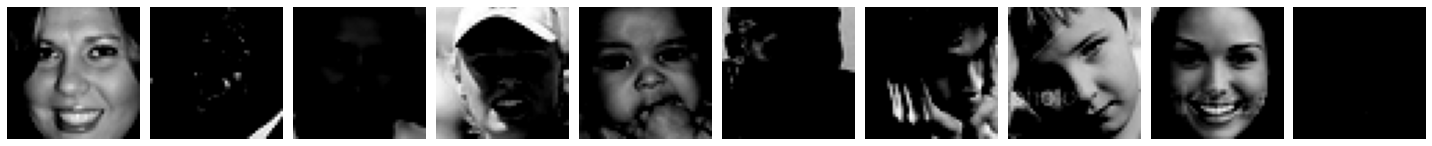

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [29]:
imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [30]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [31]:
type(mobile)

tensorflow.python.keras.engine.training.Model

In [32]:
x = mobile.layers[-6].output

In [33]:
output = Dense(units=7, activation='softmax')(x)

In [34]:
model = Model(inputs=mobile.input, outputs=output)

In [56]:
for layer in model.layers[:-50]:
    layer.trainable = False

In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [45]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=30,
    verbose=2
)

# Train for 245 steps, validate for 21 steps
# Epoch 1/30
# 245/245 - 374s - loss: 1.5718 - accuracy: 0.3859 - val_loss: 2.8528 - val_accuracy: 0.3000
# Epoch 2/30
# 245/245 - 366s - loss: 0.5321 - accuracy: 0.8849 - val_loss: 2.9035 - val_accuracy: 0.3095
# Epoch 3/30
# 245/245 - 369s - loss: 0.2010 - accuracy: 0.9947 - val_loss: 3.0462 - val_accuracy: 0.3095
# Epoch 4/30
# 245/245 - 369s - loss: 0.0888 - accuracy: 1.0000 - val_loss: 3.1220 - val_accuracy: 0.3048
# Epoch 5/30
# 245/245 - 368s - loss: 0.0489 - accuracy: 1.0000 - val_loss: 3.0192 - val_accuracy: 0.3333
# Epoch 6/30
# 245/245 - 367s - loss: 0.0315 - accuracy: 1.0000 - val_loss: 3.0804 - val_accuracy: 0.3667
# Epoch 7/30
# 245/245 - 368s - loss: 0.0218 - accuracy: 1.0000 - val_loss: 3.1756 - val_accuracy: 0.3619
# Epoch 8/30
# 245/245 - 368s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 3.2090 - val_accuracy: 0.3524
# Epoch 9/30
# 245/245 - 368s - loss: 0.0120 - accuracy: 1.0000 - val_loss: 3.2395 - val_accuracy: 0.3619
# Epoch 10/30
# 245/245 - 367s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 3.2855 - val_accuracy: 0.3476
# Epoch 11/30
# 245/245 - 368s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 3.3098 - val_accuracy: 0.3524
# Epoch 12/30
# 245/245 - 368s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 3.3762 - val_accuracy: 0.3571
# Epoch 13/30
# 245/245 - 375s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 3.4122 - val_accuracy: 0.3667
# Epoch 14/30
# 245/245 - 373s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 3.4324 - val_accuracy: 0.3619
# Epoch 15/30
# 245/245 - 404s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 3.4553 - val_accuracy: 0.3571
# Epoch 16/30
# 245/245 - 376s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.4792 - val_accuracy: 0.3619
# Epoch 17/30
# 245/245 - 368s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.5444 - val_accuracy: 0.3714
# Epoch 18/30
# 245/245 - 367s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.5626 - val_accuracy: 0.3667
# Epoch 19/30
# 245/245 - 366s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.5736 - val_accuracy: 0.3762
# Epoch 20/30
# 245/245 - 368s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.6427 - val_accuracy: 0.3714
# Epoch 21/30
# 245/245 - 368s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.6891 - val_accuracy: 0.3762
# Epoch 22/30
# 245/245 - 369s - loss: 9.3875e-04 - accuracy: 1.0000 - val_loss: 3.7031 - val_accuracy: 0.3619
# Epoch 23/30
# 245/245 - 368s - loss: 8.0026e-04 - accuracy: 1.0000 - val_loss: 3.7493 - val_accuracy: 0.3714
# Epoch 24/30
# 245/245 - 368s - loss: 6.8257e-04 - accuracy: 1.0000 - val_loss: 3.7586 - val_accuracy: 0.3667
# Epoch 25/30
# 245/245 - 367s - loss: 5.8373e-04 - accuracy: 1.0000 - val_loss: 3.7741 - val_accuracy: 0.3667
# Epoch 26/30
# 245/245 - 367s - loss: 4.9997e-04 - accuracy: 1.0000 - val_loss: 3.8296 - val_accuracy: 0.3714
# Epoch 27/30
# 245/245 - 367s - loss: 4.2978e-04 - accuracy: 1.0000 - val_loss: 3.8471 - val_accuracy: 0.3762
# Epoch 28/30
# 245/245 - 368s - loss: 3.6909e-04 - accuracy: 1.0000 - val_loss: 3.8947 - val_accuracy: 0.3714
# Epoch 29/30
# 245/245 - 368s - loss: 3.1750e-04 - accuracy: 1.0000 - val_loss: 3.9154 - val_accuracy: 0.3762
# Epoch 30/30
# 245/245 - 368s - loss: 2.7406e-04 - accuracy: 1.0000 - val_loss: 3.9255 - val_accuracy: 0.3762

# <tensorflow.python.keras.callbacks.History at 0x20e3bda0ac8>

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245 steps, validate for 21 steps
Epoch 1/10
245/245 - 22s - loss: 2.9745 - accuracy: 0.2024 - val_loss: 2.5557 - val_accuracy: 0.1810
Epoch 2/10
245/245 - 19s - loss: 0.6902 - accuracy: 0.7952 - val_loss: 3.5123 - val_accuracy: 0.1714
Epoch 3/10
245/245 - 19s - loss: 0.1936 - accuracy: 0.9840 - val_loss: 3.6023 - val_accuracy: 0.1667
Epoch 4/10
245/245 - 19s - loss: 0.0914 - accuracy: 0.9996 - val_loss: 3.6544 - val_accuracy: 0.1714
Epoch 5/10
245/245 - 19s - loss: 0.0602 - accuracy: 1.0000 - val_loss: 3.7502 - val_accuracy: 0.1619
Epoch 6/10
245/245 - 19s - loss: 0.0447 - accuracy: 1.0000 - val_loss: 3.7586 - val_accuracy: 0.1619
Epoch 7/10
245/245 - 19s - loss: 0.0354 - accuracy: 1.0000 - val_loss: 3.8590 - val_accuracy: 0.1714
Epoch 8/10
245/245 - 19s - loss: 0.0292 - accuracy: 1.0000 - val_loss: 3.8346 - val_accuracy: 0.1810
Epoch 9/10
245/245 - 19s - loss: 0.0249 - accuracy: 1.0000 - val_loss: 3.8533 - val_accuracy: 0.161

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

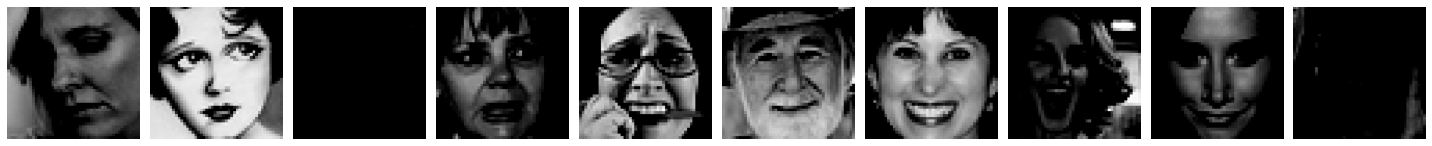

[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [33]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [34]:
test_batches.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6])

In [18]:
test_labels = test_batches.classes

In [36]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [42]:
np.round(predictions)

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
 

In [43]:
print(test_labels.shape)
print(predictions.argmax(axis=1).shape)

(10, 7)
(35,)


In [45]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
# cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
test_batches.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}

Confusion matrix, without normalization
[[1 3 0 1 0 0 0]
 [1 3 0 0 0 0 1]
 [0 0 0 0 0 3 2]
 [1 1 0 3 0 0 0]
 [0 1 0 1 1 1 1]
 [2 1 0 0 0 1 1]
 [0 0 0 0 0 0 5]]


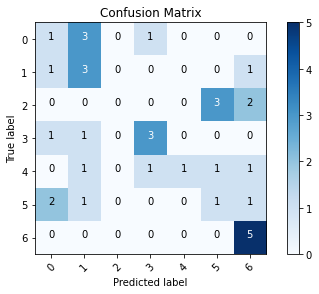

In [49]:
# 0 angry
# 1 disgusted
# 2 fearful
# 3 happy
# 4 neutral
# 5 sad
# 6 surprised

cm_plot_labels = ['0','1','2','3','4','5','6']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')